In [ ]:
# draw lhs samples
from scipy.stats import qmc, truncnorm
from matplotlib import pyplot as plt
import numpy as np

sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(n=1000)
plt.scatter(sample[:, 0], sample[:, 1])
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Latin Hypercube Sampling')
plt.show()


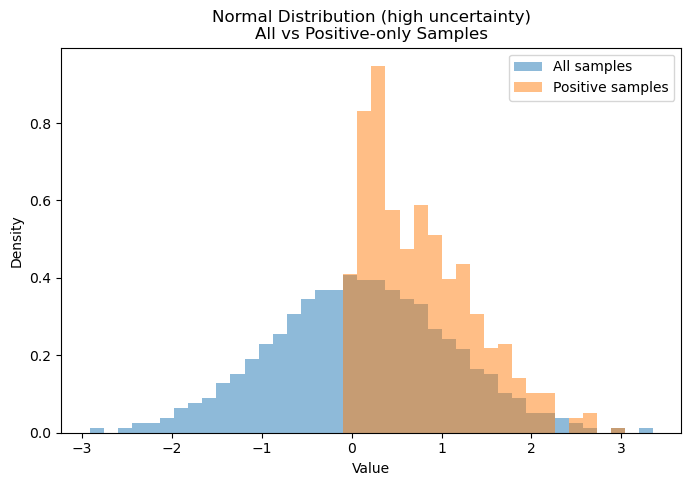

All samples:    mean=0.101, std=0.999, skew=0.021, kurt=-0.037
Positive only:  mean=0.790, std=0.628, skew=1.077, kurt=1.343


In [2]:
from scipy.stats import qmc, norm, skew, kurtosis
import numpy as np
from matplotlib import pyplot as plt

# Parameters for high relative uncertainty
mu = 0.1
sigma = 1.0  # variance/mean >> 1

N = 500

# 1. LHS sampling in [0,1]
sampler = qmc.LatinHypercube(d=1)
lhs_sample = sampler.random(n=N).flatten()

# 2. Inverse to normal
normal_samples = norm.ppf(lhs_sample, loc=mu, scale=sigma)

# 3. Plot normal distribution
plt.figure(figsize=(8, 5))
count, bins, _ = plt.hist(normal_samples, bins=40, alpha=0.5, label='All samples', density=True)

# 4. Discard negative samples, keep N=500 positive ones
positive_samples = []
while len(positive_samples) < N:
    extra = norm.rvs(loc=mu, scale=sigma, size=N)
    positive_samples.extend(extra[extra > 0])
positive_samples = np.array(positive_samples[:N])

plt.hist(positive_samples, bins=bins, alpha=0.5, label='Positive samples', density=True)

plt.title('Normal Distribution (high uncertainty)\nAll vs Positive-only Samples')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

# 5. Print statistics
def stats(arr):
    return np.mean(arr), np.std(arr), skew(arr), kurtosis(arr)

mean_all, std_all, skew_all, kurt_all = stats(normal_samples)
mean_pos, std_pos, skew_pos, kurt_pos = stats(positive_samples)

print(f"All samples:    mean={mean_all:.3f}, std={std_all:.3f}, skew={skew_all:.3f}, kurt={kurt_all:.3f}")
print(f"Positive only:  mean={mean_pos:.3f}, std={std_pos:.3f}, skew={skew_pos:.3f}, kurt={kurt_pos:.3f}")

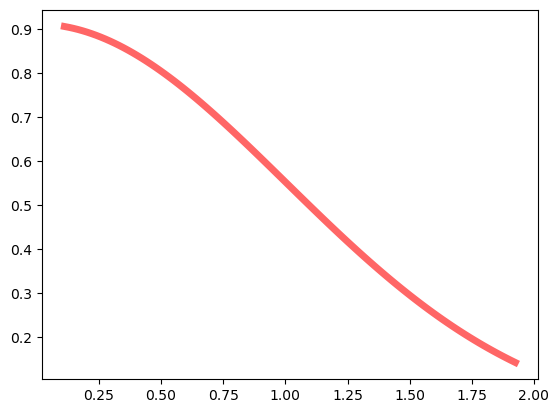

In [1]:
fig, ax = plt.subplots(1, 1)
a, b = 0.1, 2
x = np.linspace(truncnorm.ppf(0.01, a, b),
                truncnorm.ppf(0.99, a, b), 100)
ax.plot(x, truncnorm.pdf(x, a, b), 'r-', lw=5, alpha=0.6, label='truncnorm pdf')

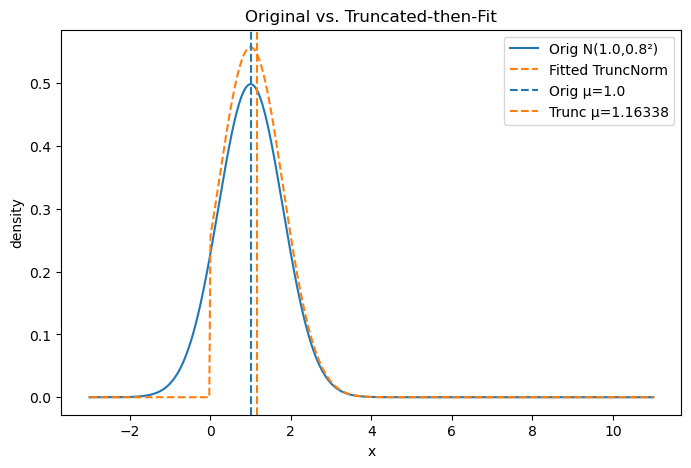

In [19]:
import numpy as np
from scipy.optimize import brentq
from scipy.stats import norm, truncnorm
import matplotlib.pyplot as plt

phi, Phi = norm.pdf, norm.cdf

def safe_lambda(alpha):
    sf = norm.sf(alpha)
    if sf == 0.0:
        return alpha + 1/alpha
    return phi(alpha) / sf

def F(alpha, m_t, v_t):
    lam   = safe_lambda(alpha)
    denom = lam - alpha
    sigma2 = (m_t/denom)**2
    inner  = 1 + alpha*lam - lam**2
    return sigma2 * inner - v_t

def solve_trunc_params(m_t, v_t):
    a_min, a_max = -10.0, 10.0
    f_min, f_max = F(a_min, m_t, v_t), F(a_max, m_t, v_t)
    while f_min * f_max > 0:
        a_min *= 2;  a_max *= 2
        if abs(a_min) > 1e6:
            raise RuntimeError("Cannot bracket root for F(α).")
        f_min, f_max = F(a_min, m_t, v_t), F(a_max, m_t, v_t)
    alpha_star = brentq(F, a_min, a_max, args=(m_t, v_t))
    lam_star   = safe_lambda(alpha_star)
    sigma_star = m_t / (lam_star - alpha_star)
    mu_star    = -alpha_star * sigma_star
    return mu_star, sigma_star

# --- parameters for the original Normal ---
mu_g    = 1.0
sigma_g = 0.8

# 1) compute the *truncated* mean & variance analytically
alpha0 = -mu_g/sigma_g
lam0   = phi(alpha0)/(1 - Phi(alpha0))
m_t    = mu_g + sigma_g * lam0
v_t    = sigma_g**2 * (1 + alpha0*lam0 - lam0**2)

# 2) solve for the equivalent (mu_t, sigma_t)
mu_t, sigma_t = solve_trunc_params(m_t, v_t)
a_t = (-mu_t)/sigma_t
b_t = np.inf
# 3) plot and compare
x_plot  = np.linspace(-3, 11, 500)
orig_pdf = norm.pdf(x_plot, loc=mu_g,    scale=sigma_g)

rv = truncnorm(a=a_t, b=b_t, loc=mu_t, scale=sigma_t)

# trunc_pdf = truncnorm.pdf(x_plot, a=a_t, b=b_t, loc=mu_t, scale=sigma_t)

plt.figure(figsize=(8,5))
plt.plot(x_plot, orig_pdf, linestyle='-',  label=f'Orig N({mu_g},{sigma_g}²)')
plt.plot(x_plot, rv.pdf(x_plot), linestyle='--', label='Fitted TruncNorm')

mu_t, var, skew, kurt = rv.stats(moments='mvsk')
plt.axvline(mu_g,    color='C0', linestyle='--', label=f'Orig μ={mu_g}')
plt.axvline(mu_t,    color='C1', linestyle='--', label=f'Trunc μ={mu_t:.5f}')

plt.title('Original vs. Truncated‐then‐Fit')
plt.xlabel('x'); plt.ylabel('density')
plt.legend(); plt.show()

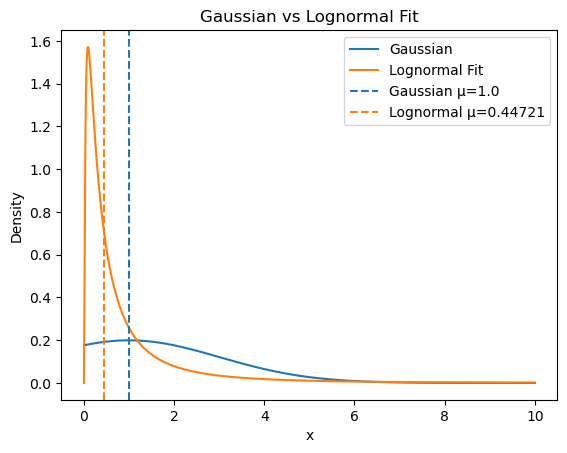

In [28]:
from scipy.stats import lognorm
def fit_lognormal(mu, sigma):
    """
    Fit a lognormal distribution to a normal distribution with
    mean mu and standard deviation sigma.
    """
    mu_lognorm = np.log(mu**2 / np.sqrt(sigma**2 + mu**2))
    sigma_lognorm = np.sqrt(np.log(1 + (sigma**2 / mu**2)))
    return mu_lognorm, sigma_lognorm

# Plot a gaussian distribution and its lognormal fit
def plot_lognormal(mu, sigma):
    mu_lognorm, sigma_lognorm = fit_lognormal(mu, sigma)
    x = np.linspace(0, 10, 1000)
    y_gaussian = norm.pdf(x, mu, sigma)
    y_lognormal = lognorm.pdf(x, s=sigma_lognorm, scale=np.exp(mu_lognorm))
    
    plt.plot(x, y_gaussian, label='Gaussian')
    plt.plot(x, y_lognormal, label='Lognormal Fit')
    plt.axvline(mu, color='C0', linestyle='--', label=f'Gaussian μ={mu}')
    plt.axvline(np.exp(mu_lognorm), color='C1', linestyle='--', label=f'Lognormal μ={np.exp(mu_lognorm):.5f}')
    plt.title('Gaussian vs Lognormal Fit')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
# Example usage
mu = 1.0
sigma = 2
plot_lognormal(mu, sigma)